# Result Visualization — FaceAPI & MobileNetV3 (K7)

In [15]:
# ==== Cell 1: setup & utils (REPLACE) ====
import os, re, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 평가 라벨(고정: face-api 7키)
LABELS = ['angry','disgusted','fearful','happy','neutral','sad','surprised']

# FaceAPI 필터
IOU_THRESH = 0.30

# 실험명 → CSV 경로 (현재 리포 구조 고정)
EXPERIMENTS = {
    # FaceAPI
    'FaceAPI_M1': 'models/faceapi_baseline/results/faceapi_M1_eval.csv',
    'FaceAPI_M2': 'models/faceapi_baseline/results/faceapi_M2_eval.csv',
    # MobileNetV3
    'Probe_M1_160':    'models/mobilenetv3_classifier/runs/probe_M1_160/test_preds.csv',
    'Finetune_M1_160': 'models/mobilenetv3_classifier/runs/finetune_M1_160/test_preds.csv',
    'Probe_M2_160':    'models/mobilenetv3_classifier/runs/probe_M2_160/test_preds.csv',
    'Finetune_M2_160': 'models/mobilenetv3_classifier/runs/finetune_M2_160/test_preds.csv',
    'Finetune_K7_160': 'models/mobilenetv3_classifier/runs/finetune_K7_160/test_preds.csv',  # 없으면 자동 스킵
}

REPORT_DIR = './reports'
os.makedirs(REPORT_DIR, exist_ok=True)

# 한글 → 영문 라벨 맵
KOR2EN = {
    '분노':'angry','혐오':'disgusted','불안':'fearful','기쁨':'happy',
    '중립':'neutral','슬픔':'sad','당황':'surprised','상처':'disgusted'
}
ALIASES = {
    'anger':'angry','disgust':'disgusted','fear':'fearful',
    'happiness':'happy','sadness':'sad','surprise':'surprised'
}

def _pick(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _normalize_label_series(s):
    def _norm(x):
        if pd.isna(x): return None
        t = str(x).strip()
        low = t.lower()
        # 숫자 인덱스(0~6) → 라벨
        if re.fullmatch(r'\d+', low):
            idx = int(low)
            if 0 <= idx < len(LABELS): return LABELS[idx]
        # 영문 직접/별칭
        if low in LABELS: return low
        if low in ALIASES: return ALIASES[low]
        # 한글
        k = t.replace(' ', '')
        if k in KOR2EN: return KOR2EN[k]
        # 혼합 표기 'happy(기쁨)'
        m = re.match(r'([a-z]+)|([가-힣]+)', low)
        if m:
            token = m.group(1) or m.group(2)
            if token in LABELS: return token
            if token in ALIASES: return ALIASES[token]
            if token in KOR2EN: return KOR2EN[token]
        return t
    return s.map(_norm)

def load_table(csv_path, labels=LABELS, iou_thresh=IOU_THRESH):
    """
    CSV → (true, pred) 정규화.
    지원 컬럼:
      - GT 후보: ['true','gt_label','label','label_en','orig_kor','orig','gt','gt_en','gt_kor','target','y']
      - PRED 후보: ['pred','pred_label','prediction','pred_en','expr_pred','y_pred','top1','top1_en']
      - 경로 후보: ['path','image','img','src','filepath','file']
      - FaceAPI 필터: 'matched'==1 | 'face_detected'==1 | 'detected'==1, 그리고 'iou'>=IOU_THRESH
      - 확률 컬럼이 존재하면 argmax로 pred 대체 가능
    반환: df_use(columns: true,pred[,path,probs...]), meta(dict)
    """
    df = pd.read_csv(csv_path)
    df.columns = [c.strip() for c in df.columns]
    meta = {'path': csv_path, 'n_raw': int(len(df)), 'filtered_by': ''}

    # FaceAPI 필터
    if 'matched' in df.columns:
        df = df[df['matched'] == 1].copy()
        meta['filtered_by'] += 'matched==1; '
    else:
        # 사용자가 제공: face_detected
        if 'face_detected' in df.columns:
            df = df[df['face_detected'] == 1].copy()
            meta['filtered_by'] += 'face_detected==1; '
        elif 'detected' in df.columns:
            df = df[df['detected'] == 1].copy()
            meta['filtered_by'] += 'detected==1; '
        if 'iou' in df.columns:
            df = df[df['iou'] >= iou_thresh].copy()
            meta['filtered_by'] += f'iou>={iou_thresh}; '

    # 컬럼 탐색
    path_col = _pick(df, ['path','image','img','src','filepath','file'])
    gt_col   = _pick(df, ['true','gt_label','label','label_en','orig_kor','orig','gt','gt_en','gt_kor','target','y'])
    pr_col   = _pick(df, ['pred','pred_label','prediction','pred_en','expr_pred','y_pred','top1','top1_en'])

    has_probs = all(c in df.columns for c in labels)

    if gt_col is None:
        raise ValueError(f"[{csv_path}] GT 컬럼 탐지 실패. 실제 컬럼: {list(df.columns)}")

    if pr_col is None and has_probs:
        argmax_idx = np.argmax(df[labels].values, axis=1)
        pred_series = pd.Series([labels[i] for i in argmax_idx], index=df.index)
    elif pr_col is not None:
        pred_series = df[pr_col]
    else:
        raise ValueError(f"[{csv_path}] PRED 없음(확률 컬럼도 없음). 실제 컬럼: {list(df.columns)}")

    true_series = df[gt_col]

    # 라벨 정규화
    true_norm = _normalize_label_series(true_series)
    pred_norm = _normalize_label_series(pred_series)

    cols = {'true': true_norm, 'pred': pred_norm}
    if path_col: cols['path'] = df[path_col]
    if has_probs:
        for c in labels: cols[c] = df[c]
    use = pd.DataFrame(cols)

    # 허용 라벨만 남김
    use = use[use['true'].isin(labels) & use['pred'].isin(labels)].copy()
    meta['n_final'] = int(len(use))
    meta['coverage'] = (meta['n_final']/meta['n_raw']) if meta['n_raw'] else None
    return use, meta

def per_class_metrics(true, pred, labels=LABELS):
    rows = []
    true = pd.Series(true); pred = pd.Series(pred)
    for c in labels:
        tp = ((true==c)&(pred==c)).sum()
        fp = ((true!=c)&(pred==c)).sum()
        fn = ((true==c)&(pred!=c)).sum()
        prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
        rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
        f1   = (2*prec*rec)/(prec+rec) if (prec+rec)>0 else 0.0
        rows.append((c, float(prec), float(rec), float(f1), int(tp), int(fp), int(fn), int((true==c).sum())))
    return pd.DataFrame(rows, columns=['class','precision','recall','f1','tp','fp','fn','support'])

def confusion(true, pred, labels=LABELS):
    cm = pd.crosstab(pd.Categorical(true, categories=labels),
                     pd.Categorical(pred, categories=labels),
                     rownames=['true'], colnames=['pred'],
                     dropna=False).fillna(0).astype(int)
    cmn = cm.div(cm.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)
    return cm, cmn

def plot_cm(cmn, labels=LABELS, title='Confusion (row-normalized)'):
    plt.figure(figsize=(7,6))
    plt.imshow(cmn.values, aspect='auto')
    plt.title(title); plt.xlabel('Predicted'); plt.ylabel('True')
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.yticks(range(len(labels)), labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            v = cmn.values[i, j]
            plt.text(j, i, f'{v:.2f}', ha='center', va='center')
    plt.colorbar(); plt.tight_layout(); plt.show()


In [16]:
# ==== Cell 2: check inputs (REPLACE) ====
EXISTING = {k:v for k,v in EXPERIMENTS.items() if os.path.exists(v)}
MISSING  = {k:v for k,v in EXPERIMENTS.items() if not os.path.exists(v)}

print("존재 CSV:", len(EXISTING))
for k,v in EXISTING.items():
    print(f" - {k}: {v}")
if MISSING:
    print("\n누락 CSV(스킵):", len(MISSING))
    for k,v in MISSING.items():
        print(f" - {k}: {v}")


존재 CSV: 7
 - FaceAPI_M1: models/faceapi_baseline/results/faceapi_M1_eval.csv
 - FaceAPI_M2: models/faceapi_baseline/results/faceapi_M2_eval.csv
 - Probe_M1_160: models/mobilenetv3_classifier/runs/probe_M1_160/test_preds.csv
 - Finetune_M1_160: models/mobilenetv3_classifier/runs/finetune_M1_160/test_preds.csv
 - Probe_M2_160: models/mobilenetv3_classifier/runs/probe_M2_160/test_preds.csv
 - Finetune_M2_160: models/mobilenetv3_classifier/runs/finetune_M2_160/test_preds.csv
 - Finetune_K7_160: models/mobilenetv3_classifier/runs/finetune_K7_160/test_preds.csv


In [17]:
# ==== Cell 3: compute & save (REPLACE) ====
summary_rows, perclass_all = [], []

for name, path in EXISTING.items():
    df_use, meta = load_table(path)
    n = len(df_use)
    acc = (df_use['true']==df_use['pred']).mean() if n else float('nan')
    m = per_class_metrics(df_use['true'], df_use['pred'])
    macro_f1 = m['f1'].mean() if len(m) else float('nan')
    cm, cmn = confusion(df_use['true'], df_use['pred'])

    # 저장
    base = name
    m.to_csv(os.path.join(REPORT_DIR, f'{base}_per_class_metrics.csv'), index=False)
    cm.to_csv(os.path.join(REPORT_DIR, f'{base}_cm_counts.csv'))
    cmn.to_csv(os.path.join(REPORT_DIR, f'{base}_cm_row_normalized.csv'))

    summary_rows.append({
        'exp': name, 'csv': path,
        'n_raw': meta['n_raw'], 'n_eval': n,
        'coverage(%)': round(meta['coverage']*100,2) if meta['coverage'] is not None else None,
        'filter': meta['filtered_by'].strip(),
        'Top1_Acc(%)': round(float(acc)*100,2) if n else None,
        'Macro-F1': round(float(macro_f1),4) if n else None
    })
    m2 = m.copy(); m2.insert(0, 'exp', name); perclass_all.append(m2)

summary_df = pd.DataFrame(summary_rows).sort_values('exp')
display(summary_df)

summary_df.to_csv(os.path.join(REPORT_DIR, 'summary_overall_7exp.csv'), index=False)
if perclass_all:
    pd.concat(perclass_all, axis=0, ignore_index=True).to_csv(
        os.path.join(REPORT_DIR, 'per_class_all_7exp.csv'), index=False)


,exp,csv,n_raw,n_eval,coverage(%),filter,Top1_Acc(%),Macro-F1
0,FaceAPI_M1,models/faceapi_baseline/results/faceapi_M1_eva...,39154,19609,50.08,face_detected==1; iou>=0.3;,42.07,0.3372
1,FaceAPI_M2,models/faceapi_baseline/results/faceapi_M2_eva...,39154,19609,50.08,face_detected==1; iou>=0.3;,32.09,0.2755
6,Finetune_K7_160,models/mobilenetv3_classifier/runs/finetune_K7...,39154,39154,100.00,,68.65,0.6546
3,Finetune_M1_160,models/mobilenetv3_classifier/runs/finetune_M1...,39154,39154,100.00,,74.94,0.6256
5,Finetune_M2_160,models/mobilenetv3_classifier/runs/finetune_M2...,39154,39154,100.00,,74.27,0.6248
2,Probe_M1_160,models/mobilenetv3_classifier/runs/probe_M1_16...,39154,39154,100.00,,50.34,0.3941
4,Probe_M2_160,models/mobilenetv3_classifier/runs/probe_M2_16...,39154,39154,100.00,,49.90,0.3902


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_15788\2285769540.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


,dataset,method,acc,macro_f1
0,M1,FaceAPI,42.07,0.3372
2,M1,Finetune,74.94,0.6256
4,M1,Probe,50.34,0.3941
1,M2,FaceAPI,32.09,0.2755
3,M2,Finetune,74.27,0.6248
5,M2,Probe,49.90,0.3902


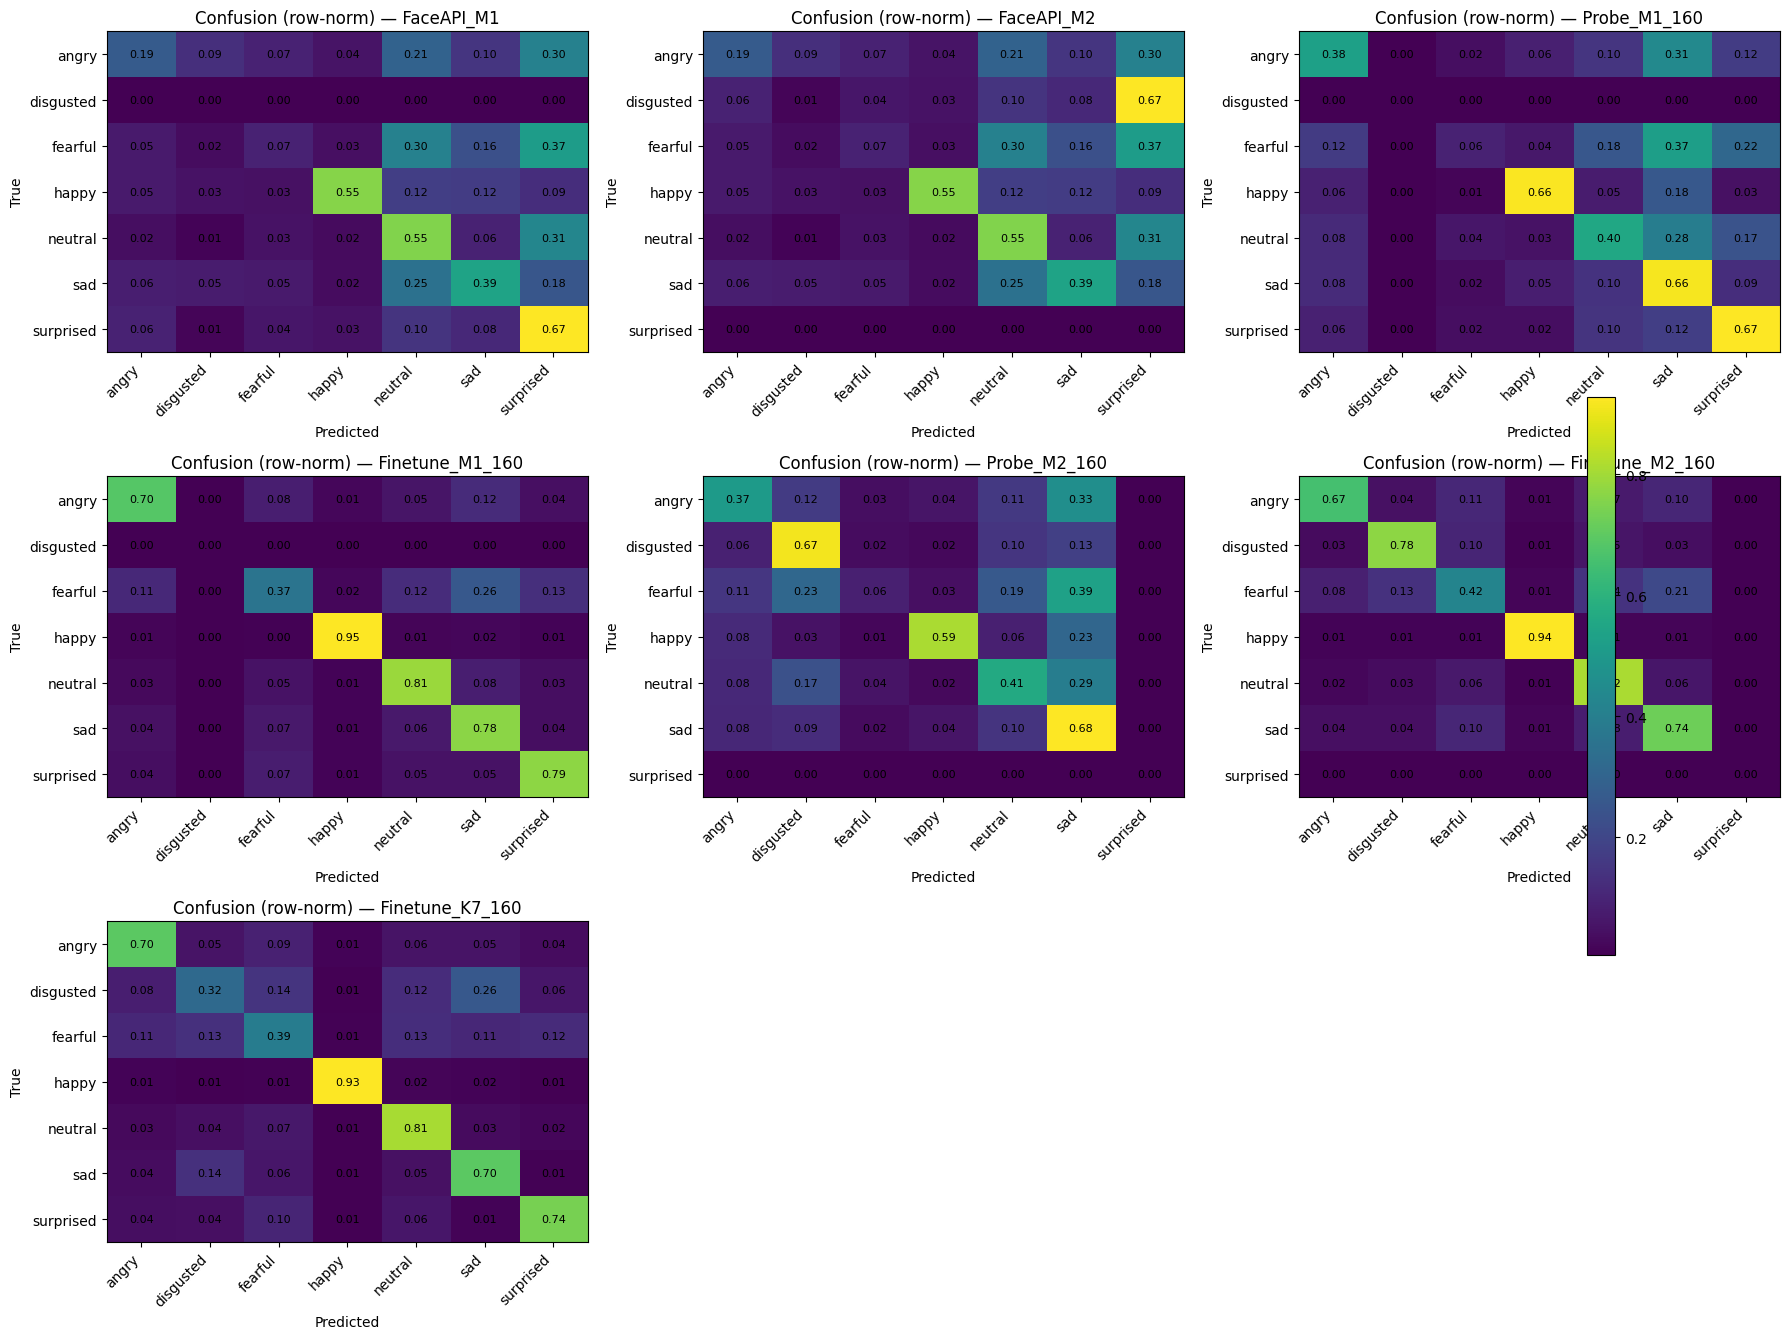

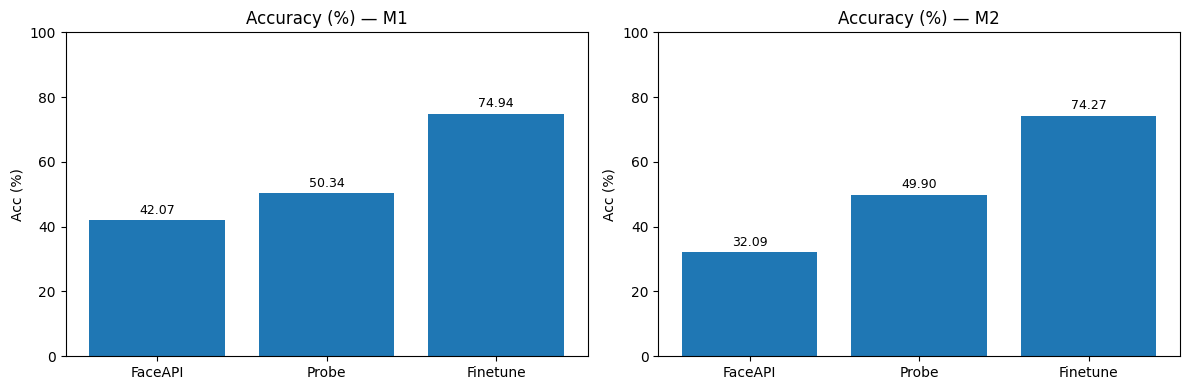

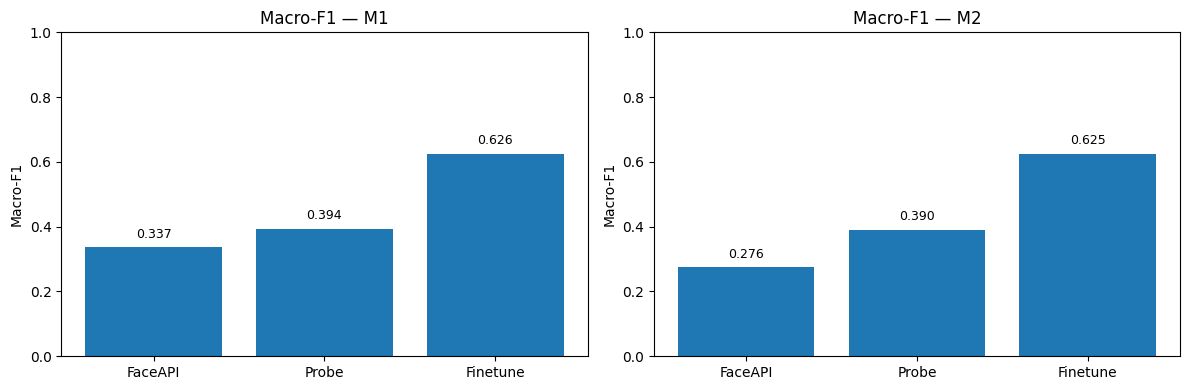

In [21]:
# ==== Cell 4: subplots (3 per row) + fine-tune comparison ====
import math

# 1) Confusion matrices in a grid (3 columns per row)
cmn_dict = {}  # name -> cm_norm (for potential later re-use)
names = list(EXISTING.keys())
n = len(names)
if n > 0:
    ncols = 3
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4.5*nrows))
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.array([axes])
    elif ncols == 1:
        axes = axes.reshape(-1,1)

    idx = 0
    for r in range(nrows):
        for c in range(ncols):
            ax = axes[r, c]
            if idx < n:
                name = names[idx]
                df_use, _ = load_table(EXISTING[name])
                if len(df_use) == 0:
                    ax.axis('off')
                    ax.set_title(f'{name} (empty)')
                else:
                    _, cmn = confusion(df_use['true'], df_use['pred'])
                    cmn_dict[name] = cmn
                    im = ax.imshow(cmn.values, aspect='auto')
                    ax.set_title(f'Confusion (row-norm) — {name}')
                    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
                    ax.set_xticks(range(len(LABELS))); ax.set_xticklabels(LABELS, rotation=45, ha='right')
                    ax.set_yticks(range(len(LABELS))); ax.set_yticklabels(LABELS)
                    for i in range(len(LABELS)):
                        for j in range(len(LABELS)):
                            v = cmn.values[i, j]
                            ax.text(j, i, f'{v:.2f}', ha='center', va='center', fontsize=8)
                idx += 1
            else:
                ax.axis('off')

    # 하나의 공용 컬러바
    fig.colorbar(im, ax=axes, fraction=0.02, pad=0.02)
    fig.tight_layout()
else:
    print("No experiments to plot.")

# 2) Fine-tuning comparison (FaceAPI vs Probe vs Finetune) for M1 and M2
#    데이터는 Cell 3에서 만든 summary_df를 사용. 없으면 파일에서 로드.
try:
    _summary = summary_df.copy()
except NameError:
    _path = os.path.join(REPORT_DIR, 'summary_overall_7exp.csv')
    if os.path.exists(_path):
        _summary = pd.read_csv(_path)
    else:
        _summary = pd.DataFrame(columns=['exp','Top1_Acc(%)','Macro-F1'])

# 정리: exp -> (dataset, method)
def parse_exp(e):
    if e.startswith('FaceAPI_'):
        ds = e.split('_')[1]  # 'M1' or 'M2'
        return ds, 'FaceAPI'
    if e.startswith('Probe_'):
        if '_M1_' in e: return 'M1', 'Probe'
        if '_M2_' in e: return 'M2', 'Probe'
    if e.startswith('Finetune_'):
        if '_M1_' in e: return 'M1', 'Finetune'
        if '_M2_' in e: return 'M2', 'Finetune'
    return None, None

_cmp_rows = []
for _, row in _summary.iterrows():
    ds, method = parse_exp(str(row.get('exp','')))
    if ds is None: continue
    acc = row.get('Top1_Acc(%)', None)
    mf1 = row.get('Macro-F1', None)
    _cmp_rows.append({'dataset': ds, 'method': method, 'acc': acc, 'macro_f1': mf1})

cmp_df = pd.DataFrame(_cmp_rows)
if not cmp_df.empty:
    # 표 출력
    display(cmp_df.sort_values(['dataset','method']))

    # Accuracy 비교: 1행 2열 (M1, M2)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for ax_idx, ds in enumerate(['M1','M2']):
        sub = cmp_df[cmp_df['dataset']==ds]
        order = ['FaceAPI','Probe','Finetune']
        sub = sub.set_index('method').reindex(order).reset_index()
        ax = axes[ax_idx]
        ax.bar(sub['method'], sub['acc'])
        ax.set_title(f'Accuracy (%) — {ds}')
        ax.set_ylim(0, 100)  # 퍼센트 스케일
        ax.set_ylabel('Acc (%)')
        for i, v in enumerate(sub['acc'].fillna(0)):
            ax.text(i, v + 1, f'{v:.2f}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

    # Macro-F1 비교: 1행 2열 (M1, M2)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for ax_idx, ds in enumerate(['M1','M2']):
        sub = cmp_df[cmp_df['dataset']==ds]
        order = ['FaceAPI','Probe','Finetune']
        sub = sub.set_index('method').reindex(order).reset_index()
        ax = axes[ax_idx]
        ax.bar(sub['method'], sub['macro_f1'])
        ax.set_title(f'Macro-F1 — {ds}')
        ax.set_ylim(0, 1)    # F1 스케일
        ax.set_ylabel('Macro-F1')
        for i, v in enumerate(sub['macro_f1'].fillna(0)):
            ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No summary to compare (check Cell 3 output).")
